Cell 1

In [983]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, gamma
from dataclasses import dataclass
from typing import List, Tuple
import pandas as pd
import time

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
GRID_SIZE = 0.5  # km x km (500m x 500m)
POPULATION_DENSITY = 4680  # Updated density: people per km²
N_AGENTS = int(POPULATION_DENSITY * GRID_SIZE ** 2)  # Now 1170 agents

# Movement parameters
AVERAGE_DISTANCE_TRAVELLED = 0.92  # km per DAY (walking only, from research)
DT = 1/6 # Time step = 1/6 of a day (every 4 hours)

# Calculate diffusion coefficient from average distance traveled PER DAY
D = (AVERAGE_DISTANCE_TRAVELLED ** 2) / (4 * 1.0)  # Still in km²/day

SIMULATION_DAYS = 50
SIMULATION_STEPS = int(SIMULATION_DAYS / DT)  # Total timesteps

# Disease parameters
INFECTIOUSNESS_THRESHOLD = 0.05  # Below this, person recovers
DECAY_MULTIPLIER = 1.0  # Controls how fast infectiousness decays after peak

# Transmission parameters
MAX_TRANSMISSION_DISTANCE = 0.005  # only 5m otherwise infection was spreading so much by long range that local social distancing didnt affect  results...
MINIMUM_PROXIMITY = 0.0  # Social distancing parameter (meters)

print(f"Simulation setup:")
print(f"Grid size: {GRID_SIZE} km x {GRID_SIZE} km")
print(f"Population: {N_AGENTS} agents")
print(f"Effective density: {N_AGENTS / (GRID_SIZE**2):.0f} per km²")
print(f"Average agent spacing: ~{np.sqrt((GRID_SIZE**2)/N_AGENTS)*1000:.1f} meters")
print(f"\nTime parameters:")
print(f"Timestep dt: {DT} days = {DT*24:.1f} hours")
print(f"Simulation duration: {SIMULATION_DAYS} days = {SIMULATION_STEPS} timesteps")
print(f"\nMovement parameters:")
print(f"Average distance travelled per day: {AVERAGE_DISTANCE_TRAVELLED} km")
print(f"Calculated diffusion coefficient D: {D:.4f} km²/day")
print(f"Expected RMS movement per timestep: {np.sqrt(4*D*DT):.4f} km = {np.sqrt(4*D*DT)*1000:.1f} m")
print(f"Expected RMS movement per day: {np.sqrt(4*D*1.0):.2f} km")
print(f"\nTransmission parameters:")
print(f"Max transmission distance: {MAX_TRANSMISSION_DISTANCE*1000:.0f} meters")
print(f"Minimum proximity (social distancing): {MINIMUM_PROXIMITY} meters")
print(f"Decay multiplier: {DECAY_MULTIPLIER}")
print(f"\nNote: Agents check for transmission {int(1/DT)} times per day")

Simulation setup:
Grid size: 0.5 km x 0.5 km
Population: 1170 agents
Effective density: 4680 per km²
Average agent spacing: ~14.6 meters

Time parameters:
Timestep dt: 0.16666666666666666 days = 4.0 hours
Simulation duration: 50 days = 300 timesteps

Movement parameters:
Average distance travelled per day: 0.92 km
Calculated diffusion coefficient D: 0.2116 km²/day
Expected RMS movement per timestep: 0.3756 km = 375.6 m
Expected RMS movement per day: 0.92 km

Transmission parameters:
Max transmission distance: 5 meters
Minimum proximity (social distancing): 0.0 meters
Decay multiplier: 1.0

Note: Agents check for transmission 6 times per day


In [475]:
print(f"DT = {DT}")
print(f"Expected RMS movement per timestep: {np.sqrt(4*D*DT)*1000:.1f} meters")

DT = 1
Expected RMS movement per timestep: 920.0 meters


Cell 2

Agent class and transmission functions defined!

Transmission probability examples:
T(0m) = 50%, T(1.5m) = 20%
Linear interpolation for 0 < d < 1.5m
Inverse square law for d > 1.5m

  At  0.0m: 1.000000 (100.00%)
  At  0.5m: 0.444444 (44.44%)
  At  1.0m: 0.250000 (25.00%)
  At  1.5m: 0.160000 (16.00%)
  At  2.0m: 0.111111 (11.11%)
  At  3.0m: 0.062500 (6.25%)
  At  5.0m: 0.027778 (2.78%)
  At 10.0m: 0.008264 (0.83%)


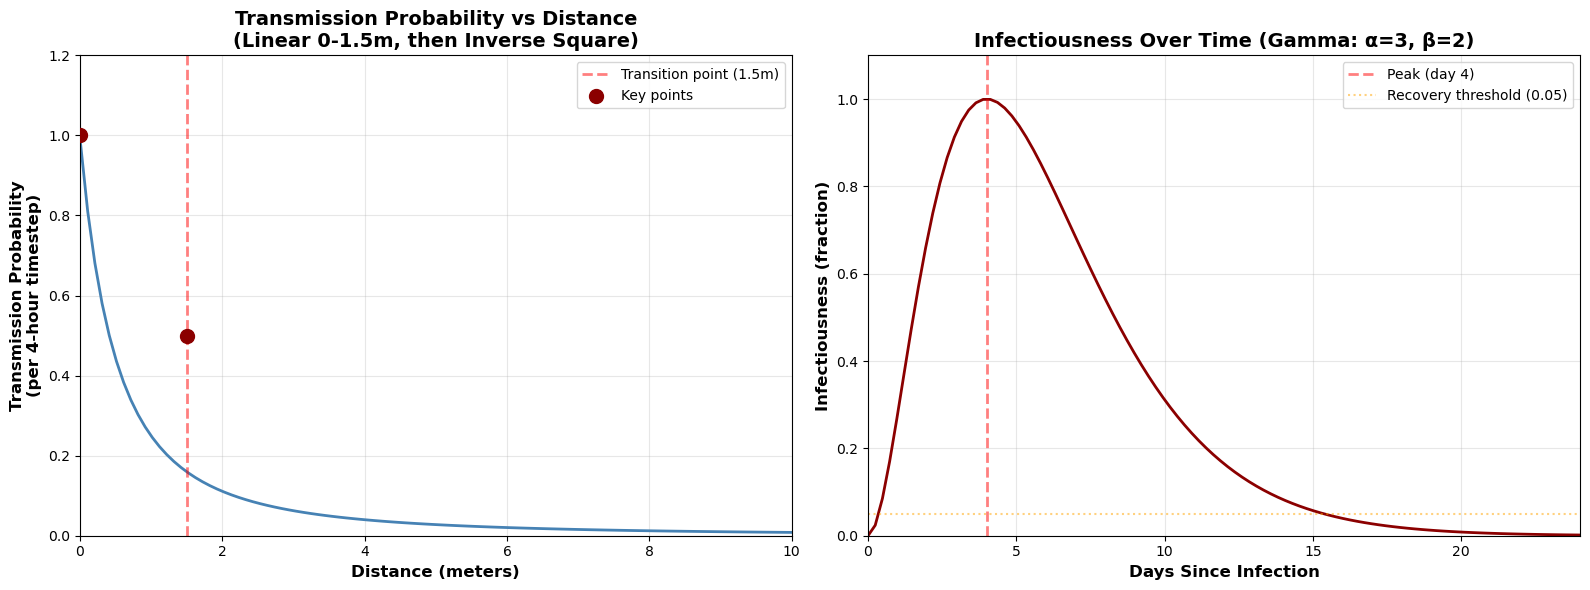


Profiles plotted and saved to: transmission_infectiousness_profiles.png


In [973]:
from scipy.stats import gamma

@dataclass
class Agent:
    """Represents a person in the simulation"""
    x: float
    y: float
    status: str
    time_infected: float = 0.0
    infected_by_generation: int = -1
    decay_multiplier: float = None
    grid_size: float = None
    
    def __post_init__(self):
        """Validate that required parameters are provided"""
        if self.decay_multiplier is None:
            self.decay_multiplier = DECAY_MULTIPLIER
        if self.grid_size is None:
            self.grid_size = GRID_SIZE
    
    def move(self, D, dt):
        """Update position based on Brownian motion"""
        sigma = np.sqrt(2 * D * dt)
        dx = np.random.normal(0, sigma)
        dy = np.random.normal(0, sigma)
        
        # Update position with periodic boundary conditions
        self.x = (self.x + dx) % self.grid_size
        self.y = (self.y + dy) % self.grid_size
    
    def get_infectiousness(self):
        """Calculate infectiousness using gamma distribution with decay multiplier"""
        if self.status != 'infected':
            return 0.0
        
        # Gamma distribution parameters
        alpha = 3.0
        beta = 2.0
        
        # Calculate the peak (mode) of the gamma distribution
        peak_day = (alpha - 1) * beta
        
        # Calculate gamma PDF at current time (continuous)
        gamma_value = gamma.pdf(self.time_infected, a=alpha, scale=beta)
        
        # Normalize so peak = 1.0
        peak_value_gamma = gamma.pdf(peak_day, a=alpha, scale=beta)
        normalized_value = gamma_value / peak_value_gamma
        
        if self.time_infected <= peak_day:
            # Before or at peak: use gamma as-is
            infectiousness = normalized_value
        else:
            # After peak: apply decay multiplier
            peak_infectiousness = 1.0
            drop_from_peak = peak_infectiousness - normalized_value
            adjusted_drop = drop_from_peak * self.decay_multiplier
            infectiousness = peak_infectiousness - adjusted_drop
        
        infectiousness = max(0.0, float(infectiousness))
        return infectiousness
    
    def update_infection_status(self, dt):
        """Update infection progression"""
        if self.status == 'infected':
            self.time_infected += dt
            
            # Gamma parameters
            alpha = 3.0
            beta = 2.0
            peak_day = (alpha - 1) * beta  # Day 4
            
            # Only check for recovery AFTER peak infectiousness
            if self.time_infected > peak_day:
                if self.get_infectiousness() < INFECTIOUSNESS_THRESHOLD:
                    self.status = 'recovered'
                    return True
        return False

def transmission_probability_distance(distance, minimum_proximity=0.0):
    """
    Transmission probability based on distance (at peak infectiousness)
    - 0 to 1.5m: LINEAR from 50% at 0m to 20% at 1.5m
    - > 1.5m: inverse square law starting from 20% at 1.5m
    
    Args:
        distance: Physical distance in km
        minimum_proximity: Minimum proximity in meters (social distancing)
    """
    # Convert distance from km to meters
    distance_m = distance * 1000
    
    # Apply minimum proximity (social distancing)
    effective_distance_m = max(distance_m, minimum_proximity)

    prob = 1/(effective_distance_m+1)**2
    return prob

    ##Code below this now pointless, but keep in case want to revert

    
    # Parameters
    r0 = 1.5  # meters - transition point
    p_at_0 = 1
    p_at_r0 = 0.5
    
    if effective_distance_m <= r0:
        # Close range: linear interpolation from p_at_0 to p_at_r0
        # P(d) = p_at_0 + (p_at_r0 - p_at_0) * (d / r0)
        prob = p_at_0 + (p_at_r0 - p_at_0) * (effective_distance_m / r0)
        return prob
    else:
        # Far range: inverse square law
        # P(r) = k / r²
        # At r = r0: p_at_r0 = k / r0²
        # Therefore: k = p_at_r0 × r0²
        k = p_at_r0 * (r0 ** 2)
        prob = k / (effective_distance_m ** 2)
        return prob

print("Agent class and transmission functions defined!")

# Create two-panel plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Transmission probability vs distance (100 points, 0-10m)
ax1 = axes[0]
distances_m = np.linspace(0.01, 10, 100)  # Start from 0.01 to avoid division issues
distances_km = distances_m / 1000
probabilities = [transmission_probability_distance(d, minimum_proximity=MINIMUM_PROXIMITY) for d in distances_km]

ax1.plot(distances_m, probabilities, linewidth=2, color='steelblue')
ax1.axvline(x=1.5, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Transition point (1.5m)')
ax1.scatter([0, 1.5], [1, 0.5], color='darkred', s=100, zorder=5, label='Key points')
if MINIMUM_PROXIMITY > 0:
    ax1.axvline(x=MINIMUM_PROXIMITY, color='purple', linestyle='-.', alpha=0.7, linewidth=2, 
                label=f'Min proximity ({MINIMUM_PROXIMITY}m)')
ax1.set_xlabel('Distance (meters)', fontsize=12, fontweight='bold')
ax1.set_ylabel(f'Transmission Probability\n(per {DT*24:.0f}-hour timestep)', fontsize=12, fontweight='bold')
ax1.set_title(f'Transmission Probability vs Distance\n(Linear 0-1.5m, then Inverse Square)', 
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 1.2)

# Print some example values
print("\nTransmission probability examples:")
print(f"T(0m) = 50%, T(1.5m) = 20%")
print(f"Linear interpolation for 0 < d < 1.5m")
print(f"Inverse square law for d > 1.5m\n")
for dist_m in [0, 0.5, 1.0, 1.5, 2, 3, 5, 10]:
    dist_km = dist_m / 1000
    prob = transmission_probability_distance(dist_km)
    print(f"  At {dist_m:4.1f}m: {prob:.6f} ({prob*100:.2f}%)")

# Plot 2: Infectiousness over time
ax2 = axes[1]
days = np.linspace(0, 24, 100)
test_agent = Agent(0, 0, 'infected', time_infected=0, infected_by_generation=0)
infectiousness_values = []
for day in days:
    test_agent.time_infected = day
    infectiousness_values.append(test_agent.get_infectiousness())

ax2.plot(days, infectiousness_values, linewidth=2, color='darkred')
ax2.axvline(x=4, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Peak (day 4)')
ax2.axhline(y=INFECTIOUSNESS_THRESHOLD, color='orange', linestyle=':', alpha=0.5, linewidth=1.5, 
            label=f'Recovery threshold ({INFECTIOUSNESS_THRESHOLD})')
ax2.set_xlabel('Days Since Infection', fontsize=12, fontweight='bold')
ax2.set_ylabel('Infectiousness (fraction)', fontsize=12, fontweight='bold')
ax2.set_title(f'Infectiousness Over Time (Gamma: α=3, β=2)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)
ax2.set_xlim(0, 24)
ax2.set_ylim(0, 1.1)

plt.tight_layout()
plt.savefig('transmission_infectiousness_profiles.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nProfiles plotted and saved to: transmission_infectiousness_profiles.png")

Cell 3

In [603]:
def initialize_population(n_agents, initial_infected, grid_size=GRID_SIZE, 
                         decay_multiplier=DECAY_MULTIPLIER, for_r0_calculation=False):
    """Initialize agents with random positions"""
    agents = []
    
    for i in range(n_agents):
        x = np.random.uniform(0, grid_size)
        y = np.random.uniform(0, grid_size)
        
        if i < initial_infected:
            # Both R0 and full epidemic: start early in infection, slightly staggered
            # This ensures consistency between R0 calculation and actual epidemic
            initial_time = np.random.uniform(0.0, 1.0)
            
            agent = Agent(x, y, 'infected', time_infected=initial_time,
                         infected_by_generation=0, decay_multiplier=decay_multiplier,
                         grid_size=grid_size)
        else:
            agent = Agent(x, y, 'susceptible', decay_multiplier=decay_multiplier,
                         grid_size=grid_size)
        
        agents.append(agent)
    
    return agents

# Test initialization
test_agents = initialize_population(N_AGENTS, INITIAL_INFECTED)
print(f"Initialized {len(test_agents)} agents")
print(f"Initial infected: {sum(1 for a in test_agents if a.status == 'infected')}")
if INITIAL_INFECTED <= 10:
    print(f"Initial infection times: {[f'{a.time_infected:.2f}' for a in test_agents if a.status == 'infected']}")
print(f"Initial susceptible: {sum(1 for a in test_agents if a.status == 'susceptible')}")

Initialized 1170 agents
Initial infected: 5
Initial infection times: ['0.73', '0.16', '0.60', '0.97', '0.18']
Initial susceptible: 1165


Cell 4

In [605]:
def calculate_distance(agent1, agent2):
    """Calculate distance between two agents considering periodic boundaries"""
    grid_size = agent1.grid_size
    dx = abs(agent1.x - agent2.x)
    dy = abs(agent1.y - agent2.y)
    
    dx = min(dx, grid_size - dx)
    dy = min(dy, grid_size - dy)
    
    return np.sqrt(dx**2 + dy**2)

def calculate_distance_coords(x1, y1, x2, y2, grid_size):
    """Calculate distance between coordinates considering periodic boundaries"""
    dx = abs(x1 - x2)
    dy = abs(y1 - y2)
    
    dx = min(dx, grid_size - dx)
    dy = min(dy, grid_size - dy)
    
    return np.sqrt(dx**2 + dy**2)

def calculate_distances_vectorized(infected_x, infected_y, susceptible_positions, grid_size):
    """Vectorized distance calculation"""
    dx = np.abs(susceptible_positions[:, 0] - infected_x)
    dy = np.abs(susceptible_positions[:, 1] - infected_y)
    
    dx = np.minimum(dx, grid_size - dx)
    dy = np.minimum(dy, grid_size - dy)
    
    return np.sqrt(dx**2 + dy**2)

def attempt_transmission(infected_agent, susceptible_agent, max_distance, minimum_proximity=0.0):
    """Attempt transmission with minimum proximity parameter"""
    distance = calculate_distance(infected_agent, susceptible_agent)
    
    if distance > max_distance:
        return False
    
    p_distance = transmission_probability_distance(distance, minimum_proximity=minimum_proximity)
    p_infectiousness = infected_agent.get_infectiousness()
    
    p_transmission = p_distance * p_infectiousness
    
    if np.random.random() < p_transmission:
        return True
    
    return False

def transmission_step_optimized(agents, max_transmission_distance=MAX_TRANSMISSION_DISTANCE,
                               minimum_proximity=0.0, for_r0_calculation=False):
    """Optimized transmission with minimum proximity parameter"""
    if for_r0_calculation:
        infected_agents = [a for a in agents if a.status == 'infected' and a.infected_by_generation == 0]
    else:
        infected_agents = [a for a in agents if a.status == 'infected']
    
    susceptible_agents = [a for a in agents if a.status == 'susceptible']
    
    if len(infected_agents) == 0 or len(susceptible_agents) == 0:
        return 0
    
    grid_size = agents[0].grid_size
    susceptible_positions = np.array([[a.x, a.y] for a in susceptible_agents])
    newly_infected_indices = set()
    
    for infected in infected_agents:
        distances = calculate_distances_vectorized(infected.x, infected.y, 
                                                   susceptible_positions, grid_size)
        
        nearby_mask = distances <= max_transmission_distance
        nearby_indices = np.where(nearby_mask)[0]
        
        if len(nearby_indices) == 0:
            continue
        
        infectiousness = infected.get_infectiousness()
        nearby_distances = distances[nearby_indices]
        
        transmission_probs = np.zeros(len(nearby_distances))
        for i, d in enumerate(nearby_distances):
            transmission_probs[i] = transmission_probability_distance(d, minimum_proximity=minimum_proximity) * infectiousness
        
        random_rolls = np.random.random(len(nearby_indices))
        successful_transmissions = nearby_indices[random_rolls < transmission_probs]
        
        for idx in successful_transmissions:
            if idx not in newly_infected_indices:
                newly_infected_indices.add(idx)
    
    new_infections = []
    for idx in newly_infected_indices:
        susceptible = susceptible_agents[idx]
        generation = infected_agents[0].infected_by_generation + 1
        new_infections.append((susceptible, generation))
    
    for agent, generation in new_infections:
        agent.status = 'infected'
        agent.time_infected = 0.0  # FIXED: was days_infected
        agent.infected_by_generation = generation
    
    return len(new_infections)

print("Highly optimized transmission logic defined!")
print(f"Using vectorized numpy operations for speed")

Highly optimized transmission logic defined!
Using vectorized numpy operations for speed


Cell 5

In [965]:
def simulate_r0(n_agents=N_AGENTS, grid_size=GRID_SIZE, decay_multiplier=DECAY_MULTIPLIER,
                max_transmission_distance=MAX_TRANSMISSION_DISTANCE, minimum_proximity=0.0,
                n_days=50, verbose=False):
    """R0 calculation with quarter-day timesteps - always uses 1 initial infected"""
    # R0 is by definition calculated with exactly 1 initial infected
    agents = initialize_population(n_agents, initial_infected=1, grid_size=grid_size,
                                  decay_multiplier=decay_multiplier, for_r0_calculation=True)
    
    total_infections = 0
    n_steps = int(n_days / DT)
    
    for step in range(n_steps):
        for agent in agents:
            agent.move(D, DT)
        
        new_infections = transmission_step_optimized(agents, 
                                                     max_transmission_distance=max_transmission_distance,
                                                     minimum_proximity=minimum_proximity,
                                                     for_r0_calculation=True)
        total_infections += new_infections
        
        for agent in agents:
            agent.update_infection_status(DT)
        
        gen0_active = any(a.infected_by_generation == 0 and a.status == 'infected' for a in agents)
        if not gen0_active and step > 0:
            if verbose:
                current_day = step * DT
                print(f"Generation-0 recovered on day {current_day:.1f} (step {step})")
            break
    
    r0 = total_infections / 1  # Always divide by 1 for R0
    
    if verbose:
        density = n_agents / (grid_size ** 2)
        print(f"R0 = {r0:.2f} (density={density:.0f}/km², grid={grid_size:.2f}km, decay={decay_multiplier:.2f}, min_prox={minimum_proximity}m)")
    
    return r0

# Multiple runs
n_runs = 20
print("\n" + "="*60)
print(f"MULTIPLE R0 CALCULATIONS ({n_runs} runs)")
print("="*60)
start = time.time()

AVERAGE_DISTANCE_TRAVELLED=0.92
MAX_TRANSMISSION_DISTANCE=0.018
r0_values = [simulate_r0(verbose=False) for _ in range(n_runs)]
end = time.time()

print(f"DT value: {DT}")
print(f"R0 values: {[f'{r:.2f}' for r in r0_values]}")
print(f"Mean R0: {np.mean(r0_values):.2f}")
print(f"Std R0: {np.std(r0_values):.2f}")
print(f"Range: [{np.min(r0_values):.2f}, {np.max(r0_values):.2f}]")
print(f"Total computation time: {end-start:.2f} seconds ({(end-start)/n_runs:.2f} sec per run)")


MULTIPLE R0 CALCULATIONS (50 runs)
DT value: 0.16666666666666666
R0 values: ['1.00', '3.00', '5.00', '2.00', '5.00', '2.00', '2.00', '2.00', '2.00', '5.00', '4.00', '3.00', '2.00', '1.00', '5.00', '5.00', '1.00', '2.00', '5.00', '5.00', '5.00', '3.00', '3.00', '4.00', '1.00', '2.00', '0.00', '2.00', '7.00', '2.00', '3.00', '2.00', '2.00', '5.00', '3.00', '3.00', '0.00', '4.00', '3.00', '4.00', '5.00', '2.00', '4.00', '3.00', '6.00', '2.00', '1.00', '1.00', '0.00', '4.00']
Mean R0: 2.96
Std R0: 1.65
Range: [0.00, 7.00]
Total computation time: 18.23 seconds (0.36 sec per run)


cell 5a1

In [743]:
from scipy.optimize import curve_fit

AVERAGE_DISTANCE_TRAVELLED=0.92 

print("="*80)
print("R0 VS POPULATION DENSITY SWEEP - DATA COLLECTION")
print("="*80)

# Keep N_AGENTS constant, vary grid_size to change density
n_agents_fixed = N_AGENTS
n_runs_per_density = 20
n_days = 50

# Define densities linearly, then calculate corresponding grid sizes
densities = np.linspace(750, 8500, 10)  # 10 linearly spaced densities
grid_sizes = [np.sqrt(n_agents_fixed / density) for density in densities]

print(f"Fixed number of agents: {n_agents_fixed}")
print(f"Testing {len(densities)} different densities")
print(f"Density range: {min(densities):.0f} to {max(densities):.0f} people/km²")
print(f"Runs per density: {n_runs_per_density}")
print(f"Total simulations: {len(densities) * n_runs_per_density}")

results_density = []

start_total = time.time()
for i, (density, grid_size) in enumerate(zip(densities, grid_sizes)):
    print(f"\n[{i+1}/{len(densities)}] Testing density = {density:.0f} people/km² (grid = {grid_size:.3f} km)...")
    
    start = time.time()
    r0_values = []
    for run in range(n_runs_per_density):
        r0 = simulate_r0(n_agents=n_agents_fixed, grid_size=grid_size, 
                        decay_multiplier=DECAY_MULTIPLIER, n_days=n_days, verbose=False)
        r0_values.append(r0)
    end = time.time()
    
    mean_r0 = np.mean(r0_values)
    std_r0 = np.std(r0_values)
    
    results_density.append({
        'density': density,
        'mean_r0': mean_r0,
        'std_r0': std_r0
    })
    
    print(f"  Mean R0 = {mean_r0:.2f} ± {std_r0:.2f} (time: {end-start:.1f}s)")

end_total = time.time()

df_density = pd.DataFrame(results_density)
df_density.to_csv('r0_vs_density.csv', index=False)

print("\n" + "="*80)
print("DENSITY SWEEP COMPLETE")
print("="*80)
print(f"Total time: {end_total-start_total:.1f} seconds")
print(f"Results saved to: r0_vs_density.csv")
print("\nSummary:")
print(df_density.to_string(index=False))

R0 VS POPULATION DENSITY SWEEP - DATA COLLECTION
Fixed number of agents: 1170
Testing 10 different densities
Density range: 750 to 8500 people/km²
Runs per density: 20
Total simulations: 200

[1/10] Testing density = 750 people/km² (grid = 1.249 km)...
  Mean R0 = 0.55 ± 1.02 (time: 4.9s)

[2/10] Testing density = 1611 people/km² (grid = 0.852 km)...
  Mean R0 = 0.80 ± 0.93 (time: 5.0s)

[3/10] Testing density = 2472 people/km² (grid = 0.688 km)...
  Mean R0 = 1.85 ± 1.46 (time: 5.0s)

[4/10] Testing density = 3333 people/km² (grid = 0.592 km)...
  Mean R0 = 1.60 ± 1.36 (time: 5.1s)

[5/10] Testing density = 4194 people/km² (grid = 0.528 km)...
  Mean R0 = 2.70 ± 1.14 (time: 5.2s)

[6/10] Testing density = 5056 people/km² (grid = 0.481 km)...
  Mean R0 = 2.55 ± 1.36 (time: 5.1s)

[7/10] Testing density = 5917 people/km² (grid = 0.445 km)...
  Mean R0 = 3.15 ± 1.74 (time: 5.2s)

[8/10] Testing density = 6778 people/km² (grid = 0.415 km)...
  Mean R0 = 4.50 ± 1.91 (time: 5.5s)

[9/10] Te

cell 5a2

R0 VS POPULATION DENSITY - PLOTTING
Linear fit:
  R0 = 0.000555 × density + 0.09
  Slope = 0.000555
  Intercept = 0.09


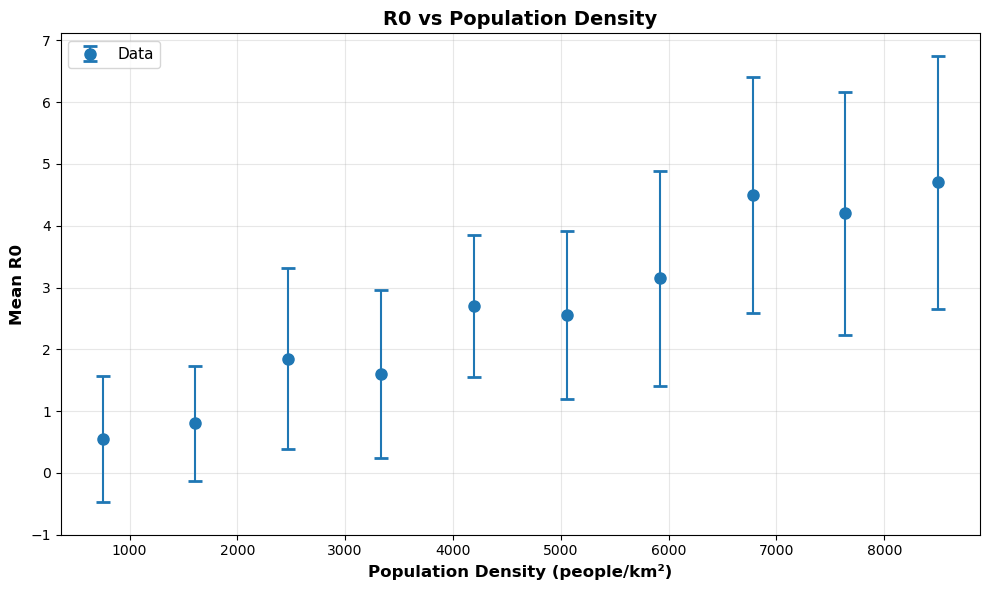


Plot saved to: r0_vs_density.png


In [745]:
print("="*80)
print("R0 VS POPULATION DENSITY - PLOTTING")
print("="*80)

# Linear function for curve_fit
def linear(x, m, c):
    return m * x + c

# Fit linear model
params, _ = curve_fit(linear, df_density['density'], df_density['mean_r0'])

print("Linear fit:")
print(f"  R0 = {params[0]:.6f} × density + {params[1]:.2f}")
print(f"  Slope = {params[0]:.6f}")
print(f"  Intercept = {params[1]:.2f}")

# Plot with error bars and line of best fit
plt.figure(figsize=(10, 6))
plt.errorbar(df_density['density'], df_density['mean_r0'], 
             yerr=df_density['std_r0'], fmt='o', markersize=8, capsize=5, capthick=2, 
             label='Data')

plt.xlabel('Population Density (people/km²)', fontsize=12, fontweight='bold')
plt.ylabel('Mean R0', fontsize=12, fontweight='bold')
plt.title('R0 vs Population Density', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.ylim(bottom=-1)
plt.tight_layout()
plt.savefig('r0_vs_density.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPlot saved to: r0_vs_density.png")

cell 5b1

In [883]:
from scipy.optimize import curve_fit

print("="*80)
print("R0 VS DECAY MULTIPLIER (RECOVERY TIME) SWEEP - DATA COLLECTION")
print("="*80)

n_agents_fixed = N_AGENTS
grid_size_fixed = GRID_SIZE
n_runs_per_multiplier = 20
n_days = 50

# Decay multipliers: 5 points below 1, 1 point at 1, 5 points above 1
decay_multipliers = np.concatenate([
    np.linspace(0.2, 0.9, 5),
    [1.0],
    np.linspace(1.1, 2.5, 5)
])

print(f"Fixed: {n_agents_fixed} agents, {grid_size_fixed} km grid")
print(f"Testing {len(decay_multipliers)} different decay multipliers")
print(f"Decay multipliers: {[f'{d:.2f}' for d in decay_multipliers]}")
print(f"Runs per multiplier: {n_runs_per_multiplier}")
print(f"Total simulations: {len(decay_multipliers) * n_runs_per_multiplier}")

results_decay = []

start_total = time.time()
for i, decay_mult in enumerate(decay_multipliers):
    print(f"\n[{i+1}/{len(decay_multipliers)}] Testing decay_multiplier = {decay_mult:.2f}...")
    
    start = time.time()
    r0_values = []
    for run in range(n_runs_per_multiplier):
        r0 = simulate_r0(n_agents=n_agents_fixed, grid_size=grid_size_fixed,
                        decay_multiplier=decay_mult, n_days=n_days, verbose=False)
        r0_values.append(r0)
    end = time.time()
    
    mean_r0 = np.mean(r0_values)
    std_r0 = np.std(r0_values)
    
    results_decay.append({
        'decay_multiplier': decay_mult,
        'mean_r0': mean_r0,
        'std_r0': std_r0
    })
    
    print(f"  Mean R0 = {mean_r0:.2f} ± {std_r0:.2f} (time: {end-start:.1f}s)")

end_total = time.time()

df_decay = pd.DataFrame(results_decay)
df_decay.to_csv('r0_vs_decay_multiplier.csv', index=False)

print("\n" + "="*80)
print("DECAY MULTIPLIER SWEEP COMPLETE")
print("="*80)
print(f"Total time: {end_total-start_total:.1f} seconds")
print(f"Results saved to: r0_vs_decay_multiplier.csv")
print("\nSummary:")
print(df_decay.to_string(index=False))

R0 VS DECAY MULTIPLIER (RECOVERY TIME) SWEEP - DATA COLLECTION
Fixed: 1170 agents, 0.5 km grid
Testing 11 different decay multipliers
Decay multipliers: ['0.20', '0.38', '0.55', '0.72', '0.90', '1.00', '1.10', '1.45', '1.80', '2.15', '2.50']
Runs per multiplier: 20
Total simulations: 220

[1/11] Testing decay_multiplier = 0.20...
  Mean R0 = 10.95 ± 3.22 (time: 17.2s)

[2/11] Testing decay_multiplier = 0.38...
  Mean R0 = 9.00 ± 2.86 (time: 16.9s)

[3/11] Testing decay_multiplier = 0.55...
  Mean R0 = 7.90 ± 2.53 (time: 16.8s)

[4/11] Testing decay_multiplier = 0.72...
  Mean R0 = 4.35 ± 2.48 (time: 16.4s)

[5/11] Testing decay_multiplier = 0.90...
  Mean R0 = 2.95 ± 1.28 (time: 16.0s)

[6/11] Testing decay_multiplier = 1.00...
  Mean R0 = 2.40 ± 1.62 (time: 4.8s)

[7/11] Testing decay_multiplier = 1.10...
  Mean R0 = 1.15 ± 0.85 (time: 3.8s)

[8/11] Testing decay_multiplier = 1.45...
  Mean R0 = 1.45 ± 1.16 (time: 2.9s)

[9/11] Testing decay_multiplier = 1.80...
  Mean R0 = 1.45 ± 1.1

cell 5b2

R0 VS DECAY MULTIPLIER - PLOTTING


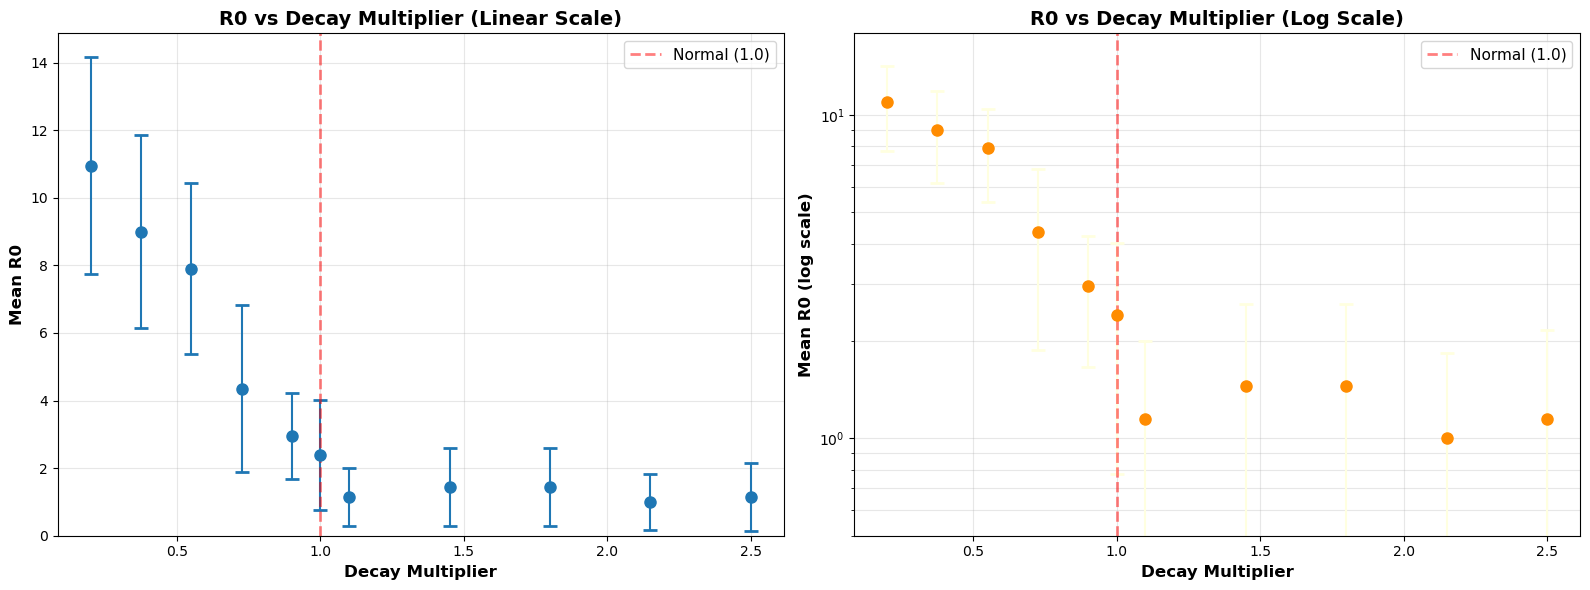


Plot saved to: r0_vs_decay_multiplier.png


In [885]:
print("="*80)
print("R0 VS DECAY MULTIPLIER - PLOTTING")
print("="*80)

# Create two-panel plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: R0 vs Decay Multiplier (linear scale)
ax1 = axes[0]
ax1.errorbar(df_decay['decay_multiplier'], df_decay['mean_r0'], 
             yerr=df_decay['std_r0'], fmt='o', markersize=8,  capsize=5, capthick=2)
ax1.axvline(x=1.0, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Normal (1.0)')
ax1.set_xlabel('Decay Multiplier', fontsize=12, fontweight='bold')
ax1.set_ylabel('Mean R0', fontsize=12, fontweight='bold')
ax1.set_title('R0 vs Decay Multiplier (Linear Scale)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)
ax1.set_ylim(bottom=0)

# Plot 2: Log(R0) vs Decay Multiplier
ax2 = axes[1]
ax2.errorbar(df_decay['decay_multiplier'], df_decay['mean_r0'], 
             yerr=df_decay['std_r0'], fmt='o', markersize=8,
             color='darkorange', ecolor='lightyellow', capsize=5, capthick=2)
ax2.axvline(x=1.0, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Normal (1.0)')
ax2.set_xlabel('Decay Multiplier', fontsize=12, fontweight='bold')
ax2.set_ylabel('Mean R0 (log scale)', fontsize=12, fontweight='bold')
ax2.set_title('R0 vs Decay Multiplier (Log Scale)', fontsize=14, fontweight='bold')
ax2.set_yscale('log')
ax2.set_ylim(bottom=0.5)
ax2.grid(True, alpha=0.3, which='both')
ax2.legend(fontsize=11)

plt.tight_layout()
plt.savefig('r0_vs_decay_multiplier.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPlot saved to: r0_vs_decay_multiplier.png")

Cell 5c1

In [985]:
from scipy.optimize import curve_fit

print("="*80)
print("R0 VS MINIMUM PROXIMITY (SOCIAL DISTANCING) SWEEP - DATA COLLECTION")
print("="*80)

n_agents_fixed = N_AGENTS
grid_size_fixed = GRID_SIZE
decay_mult_fixed = DECAY_MULTIPLIER
n_runs_per_proximity = 20
#n_days = 20

# Minimum proximity values: 0m (no distancing) to 5m (strict distancing)
minimum_proximities = np.linspace(0, 4, 10)

print(f"Fixed: {n_agents_fixed} agents, {grid_size_fixed} km grid, decay={decay_mult_fixed}")
print(f"Testing {len(minimum_proximities)} different minimum proximity values")
print(f"Minimum proximity range: {min(minimum_proximities):.1f}m to {max(minimum_proximities):.1f}m")
print(f"Runs per proximity: {n_runs_per_proximity}")
print(f"Total simulations: {len(minimum_proximities) * n_runs_per_proximity}")

results_proximity = []

start_total = time.time()
for i, min_prox in enumerate(minimum_proximities):
    print(f"\n[{i+1}/{len(minimum_proximities)}] Testing minimum proximity = {min_prox:.1f}m...")
    
    start = time.time()
    r0_values = []
    for run in range(n_runs_per_proximity):
        r0 = simulate_r0(n_agents=n_agents_fixed, grid_size=grid_size_fixed,
                        decay_multiplier=decay_mult_fixed, minimum_proximity=min_prox,
                        n_days=n_days, verbose=False)
        r0_values.append(r0)
    end = time.time()
    
    mean_r0 = np.mean(r0_values)
    std_r0 = np.std(r0_values)
    
    results_proximity.append({
        'minimum_proximity': min_prox,
        'mean_r0': mean_r0,
        'sem_r0': stats.sem(r0_values)
    })
    
    print(f"  Mean R0 = {mean_r0:.2f} ± {std_r0:.2f} (time: {end-start:.1f}s)")

end_total = time.time()

df_proximity = pd.DataFrame(results_proximity)
df_proximity.to_csv('r0_vs_minimum_proximity.csv', index=False)

print("\n" + "="*80)
print("MINIMUM PROXIMITY SWEEP COMPLETE")
print("="*80)
print(f"Total time: {end_total-start_total:.1f} seconds")
print(f"Results saved to: r0_vs_minimum_proximity.csv")
print("\nSummary:")
print(df_proximity.to_string(index=False))

R0 VS MINIMUM PROXIMITY (SOCIAL DISTANCING) SWEEP - DATA COLLECTION
Fixed: 1170 agents, 0.5 km grid, decay=1.0
Testing 10 different minimum proximity values
Minimum proximity range: 0.0m to 4.0m
Runs per proximity: 20
Total simulations: 200

[1/10] Testing minimum proximity = 0.0m...
  Mean R0 = 3.10 ± 1.55 (time: 7.4s)

[2/10] Testing minimum proximity = 0.4m...
  Mean R0 = 2.90 ± 1.64 (time: 7.3s)

[3/10] Testing minimum proximity = 0.9m...
  Mean R0 = 2.60 ± 1.69 (time: 7.3s)

[4/10] Testing minimum proximity = 1.3m...
  Mean R0 = 2.40 ± 1.53 (time: 7.3s)

[5/10] Testing minimum proximity = 1.8m...
  Mean R0 = 1.80 ± 1.12 (time: 7.5s)

[6/10] Testing minimum proximity = 2.2m...
  Mean R0 = 2.15 ± 1.11 (time: 7.4s)

[7/10] Testing minimum proximity = 2.7m...
  Mean R0 = 2.55 ± 1.88 (time: 7.8s)

[8/10] Testing minimum proximity = 3.1m...
  Mean R0 = 2.45 ± 1.16 (time: 7.4s)

[9/10] Testing minimum proximity = 3.6m...
  Mean R0 = 2.10 ± 1.51 (time: 7.3s)

[10/10] Testing minimum proxi

cell 5c2

R0 VS MINIMUM PROXIMITY - PLOTTING


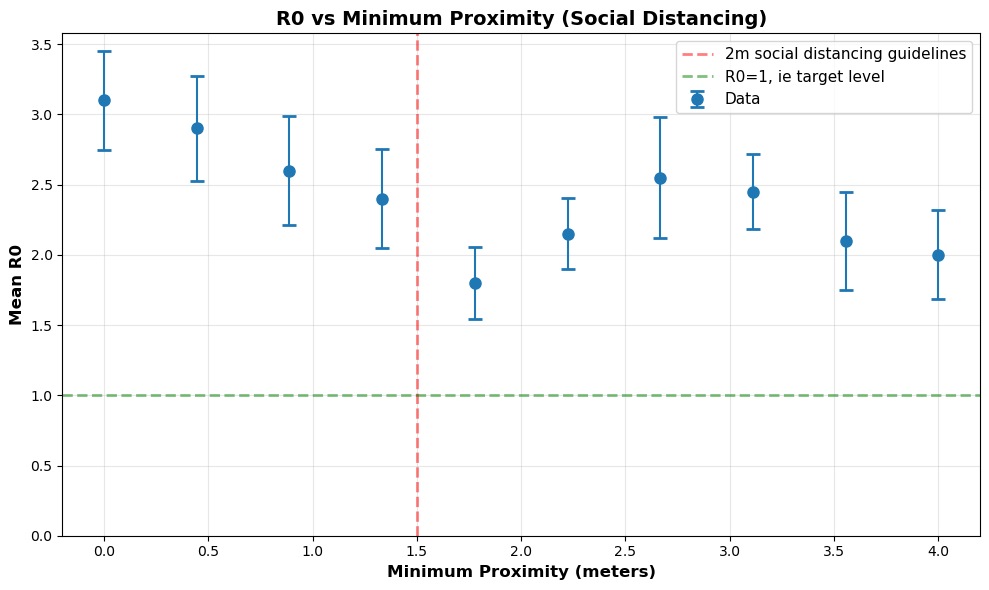


Plot saved to: r0_vs_minimum_proximity.png


In [987]:
print("="*80)
print("R0 VS MINIMUM PROXIMITY - PLOTTING")
print("="*80)

# Plot with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(df_proximity['minimum_proximity'], df_proximity['mean_r0'], 
             yerr=df_proximity['sem_r0'], fmt='o', markersize=8, capsize=5, capthick=2, 
             label='Data')

plt.xlabel('Minimum Proximity (meters)', fontsize=12, fontweight='bold')
plt.ylabel('Mean R0', fontsize=12, fontweight='bold')
plt.title('R0 vs Minimum Proximity (Social Distancing)', fontsize=14, fontweight='bold')
plt.axvline(x=1.5, color='red', linestyle='--', alpha=0.5, linewidth=2, label='2m social distancing guidelines')
plt.axhline(y=1, color='green', linestyle='--', alpha=0.5, linewidth=2, label='R0=1, ie target level')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.ylim(bottom=0)

plt.tight_layout()
plt.savefig('r0_vs_minimum_proximity.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPlot saved to: r0_vs_minimum_proximity.png")

Cell 6

In [900]:
def simulate_epidemic(n_days=SIMULATION_DAYS, initial_infected=INITIAL_INFECTED, verbose=True):
    """
    Full epidemic simulation with quarter-day timesteps
    """
    agents = initialize_population(N_AGENTS, initial_infected, for_r0_calculation=False)
    
    # Track unique agents that have ever been infected
    ever_infected_ids = set()
    
    # Add initial infected to the set
    for agent in agents:
        if agent.status == 'infected':
            ever_infected_ids.add(id(agent))
    
    stats = {
        'day': [],
        'susceptible': [],
        'infected': [],
        'recovered': [],
        'cumulative_infections': []
    }
    
    n_steps = int(n_days / DT)
    
    for step in range(n_steps + 1):
        # Move all agents (skip on step 0)
        if step > 0:
            for agent in agents:
                agent.move(D, DT)
            
            # Attempt transmissions
            new_infections = transmission_step_optimized(agents, for_r0_calculation=False)
            
            # Update set of ever-infected agents
            for agent in agents:
                if agent.status == 'infected':
                    ever_infected_ids.add(id(agent))
            
            # Update infection status
            for agent in agents:
                agent.update_infection_status(DT)
        
        # Record statistics every 4 steps (once per day)
        if step % 4 == 0:  # Record daily, not every timestep
            current_day = step * DT
            n_susceptible = sum(1 for a in agents if a.status == 'susceptible')
            n_infected = sum(1 for a in agents if a.status == 'infected')
            n_recovered = sum(1 for a in agents if a.status == 'recovered')
            cumulative = len(ever_infected_ids)
            
            stats['day'].append(current_day)
            stats['susceptible'].append(n_susceptible)
            stats['infected'].append(n_infected)
            stats['recovered'].append(n_recovered)
            stats['cumulative_infections'].append(cumulative)
            
            if verbose and int(current_day) % 10 == 0:
                print(f"Day {int(current_day)}: S={n_susceptible}, I={n_infected}, R={n_recovered}, Cumulative={cumulative}")
    
    if verbose:
        final_cumulative = stats['cumulative_infections'][-1]
        print(f"\nFinal statistics:")
        print(f"Total infected: {final_cumulative} ({100*final_cumulative/N_AGENTS:.1f}%)")
        print(f"Final recovered: {stats['recovered'][-1]}")
        print(f"Remaining susceptible: {stats['susceptible'][-1]}")
    
    return stats, agents

# Run full epidemic simulation
print("\n" + "="*60)
print("RUNNING FULL EPIDEMIC SIMULATION")
print("="*60)
start = time.time()
epidemic_stats, final_agents = simulate_epidemic(n_days=70,initial_infected=1)
end = time.time()
print(f"\nComputation time: {end-start:.2f} seconds")


RUNNING FULL EPIDEMIC SIMULATION
Day 0: S=1169, I=1, R=0, Cumulative=1
Day 10: S=1142, I=28, R=0, Cumulative=28
Day 20: S=979, I=184, R=7, Cumulative=191
Day 30: S=398, I=711, R=61, Cumulative=772
Day 40: S=113, I=623, R=434, Cumulative=1057
Day 50: S=77, I=122, R=971, Cumulative=1093
Day 60: S=73, I=9, R=1088, Cumulative=1097
Day 70: S=73, I=2, R=1095, Cumulative=1097

Final statistics:
Total infected: 1097 (93.8%)
Final recovered: 1095
Remaining susceptible: 73

Computation time: 11.85 seconds


Cell 7

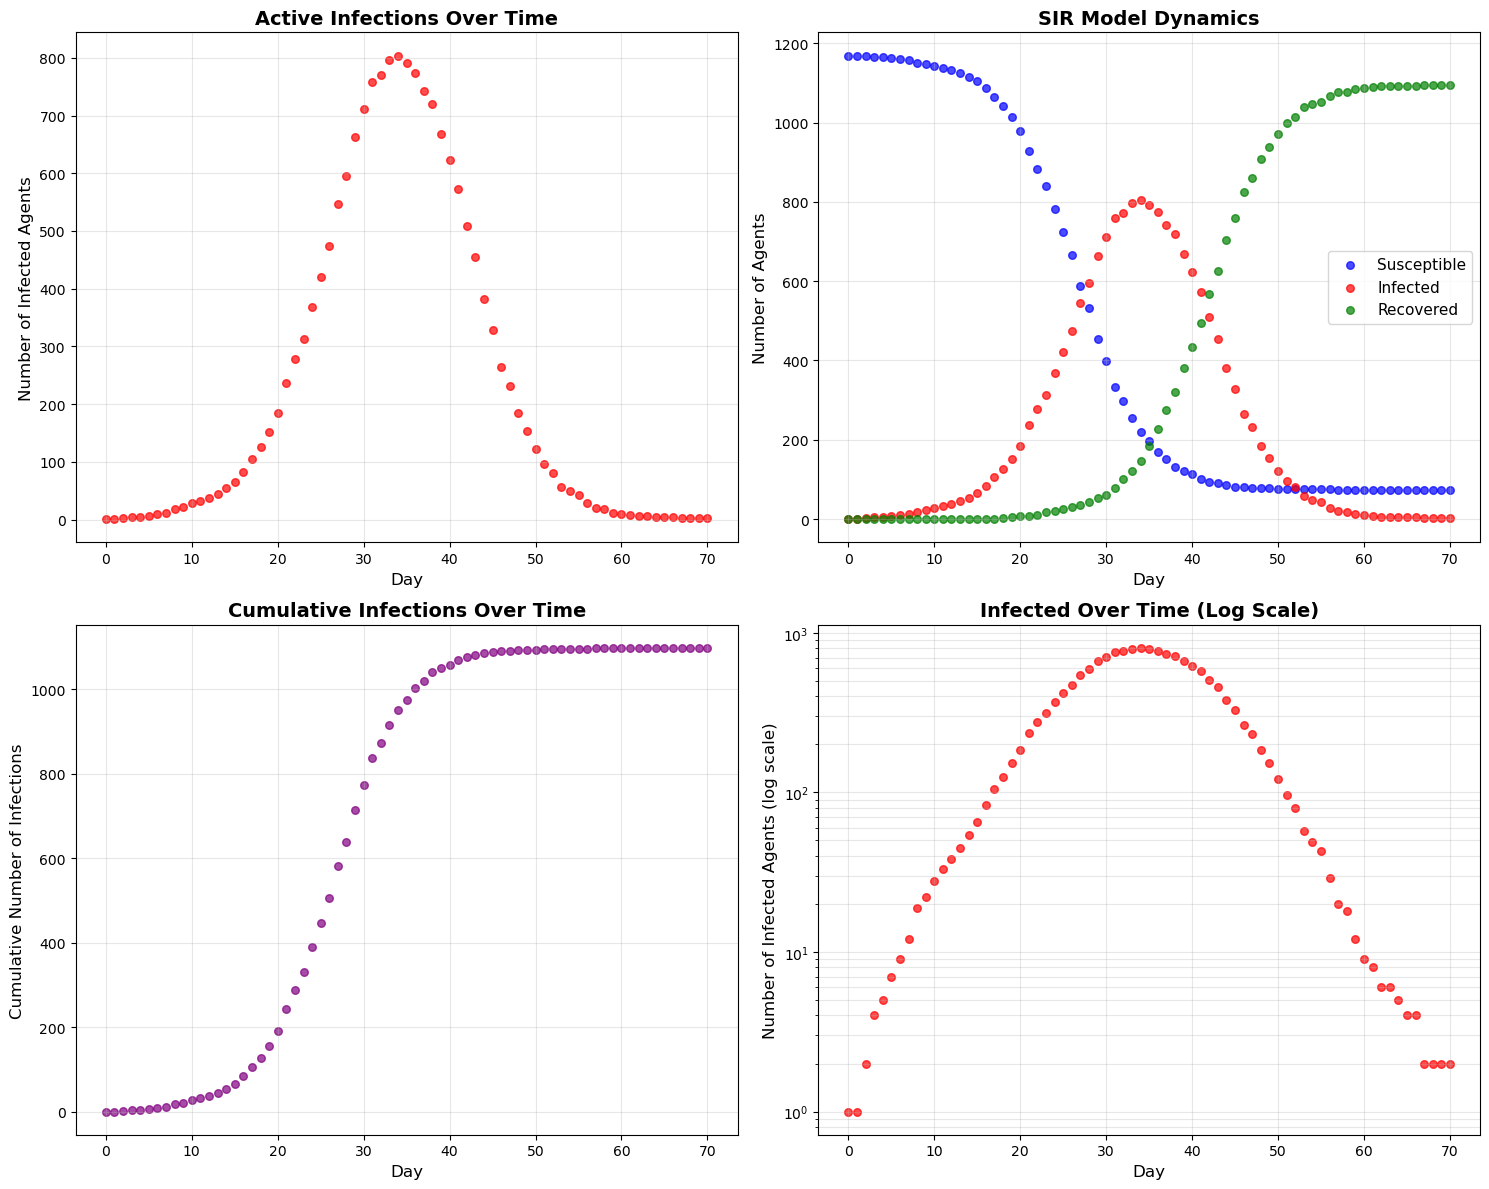


Visualization complete! Saved as 'covid_simulation_results.png'


In [902]:
#maybe improve this by instead plotting these graphs at different parameter values
#- eg to show changes in cumulative infections?
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Infected over time
ax1 = axes[0, 0]
ax1.scatter(epidemic_stats['day'], epidemic_stats['infected'], c='red', s=30, alpha=0.7)
ax1.set_xlabel('Day', fontsize=12)
ax1.set_ylabel('Number of Infected Agents', fontsize=12)
ax1.set_title('Active Infections Over Time', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: All compartments
ax2 = axes[0, 1]
ax2.scatter(epidemic_stats['day'], epidemic_stats['susceptible'], c='blue', s=30, alpha=0.7, label='Susceptible')
ax2.scatter(epidemic_stats['day'], epidemic_stats['infected'], c='red', s=30, alpha=0.7, label='Infected')
ax2.scatter(epidemic_stats['day'], epidemic_stats['recovered'], c='green', s=30, alpha=0.7, label='Recovered')
ax2.set_xlabel('Day', fontsize=12)
ax2.set_ylabel('Number of Agents', fontsize=12)
ax2.set_title('SIR Model Dynamics', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)

# Plot 3: Cumulative infections
ax3 = axes[1, 0]
ax3.scatter(epidemic_stats['day'], epidemic_stats['cumulative_infections'], c='purple', s=30, alpha=0.7)
ax3.set_xlabel('Day', fontsize=12)
ax3.set_ylabel('Cumulative Number of Infections', fontsize=12)
ax3.set_title('Cumulative Infections Over Time', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: Log scale for infected (to see exponential growth)
ax4 = axes[1, 1]
infected_nonzero = [max(i, 0.1) for i in epidemic_stats['infected']]  # Avoid log(0)
ax4.scatter(epidemic_stats['day'], infected_nonzero, c='red', s=30, alpha=0.7)
ax4.set_yscale('log')
ax4.set_xlabel('Day', fontsize=12)
ax4.set_ylabel('Number of Infected Agents (log scale)', fontsize=12)
ax4.set_title('Infected Over Time (Log Scale)', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig('covid_simulation_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization complete! Saved as 'covid_simulation_results.png'")

for crcuit breaker - reduce D to 0, if doesnt stop outbreak, then only allow transmissions
once per day...

Cell 8

CIRCUIT BREAKER COMPARISON - VARYING TRIGGER THRESHOLDS

Running simulation with lockdown trigger = 10%
Circuit breaker parameters:
  Lockdown triggers at: 10% infected
  Lockdown lifts at: 5% infected
  Lockdown movement: 10% of normal
  Lockdown transmission: 25% of normal

Day 0: S=1165, I=5, R=0, Cumulative=5 | 🔓 Normal
Day 10: S=1126, I=44, R=0, Cumulative=44 | 🔓 Normal
🔒 LOCKDOWN TRIGGERED at day 14.2 (10.2% infected)
Day 20: S=988, I=169, R=13, Cumulative=182 | 🔒 LOCKDOWN
Day 30: S=920, I=125, R=125, Cumulative=250 | 🔒 LOCKDOWN
Day 40: S=882, I=67, R=221, Cumulative=288 | 🔒 LOCKDOWN
🔓 LOCKDOWN LIFTED at day 42.0 (5.0% infected)
Day 50: S=787, I=108, R=275, Cumulative=383 | 🔓 Normal
🔒 LOCKDOWN TRIGGERED at day 50.8 (10.0% infected)
Day 60: S=732, I=123, R=315, Cumulative=438 | 🔒 LOCKDOWN
🔓 LOCKDOWN LIFTED at day 66.0 (4.6% infected)
Day 70: S=697, I=60, R=413, Cumulative=473 | 🔓 Normal
🔒 LOCKDOWN TRIGGERED at day 78.8 (10.0% infected)
Day 80: S=605, I=118, R=447, Cumulative=565 |

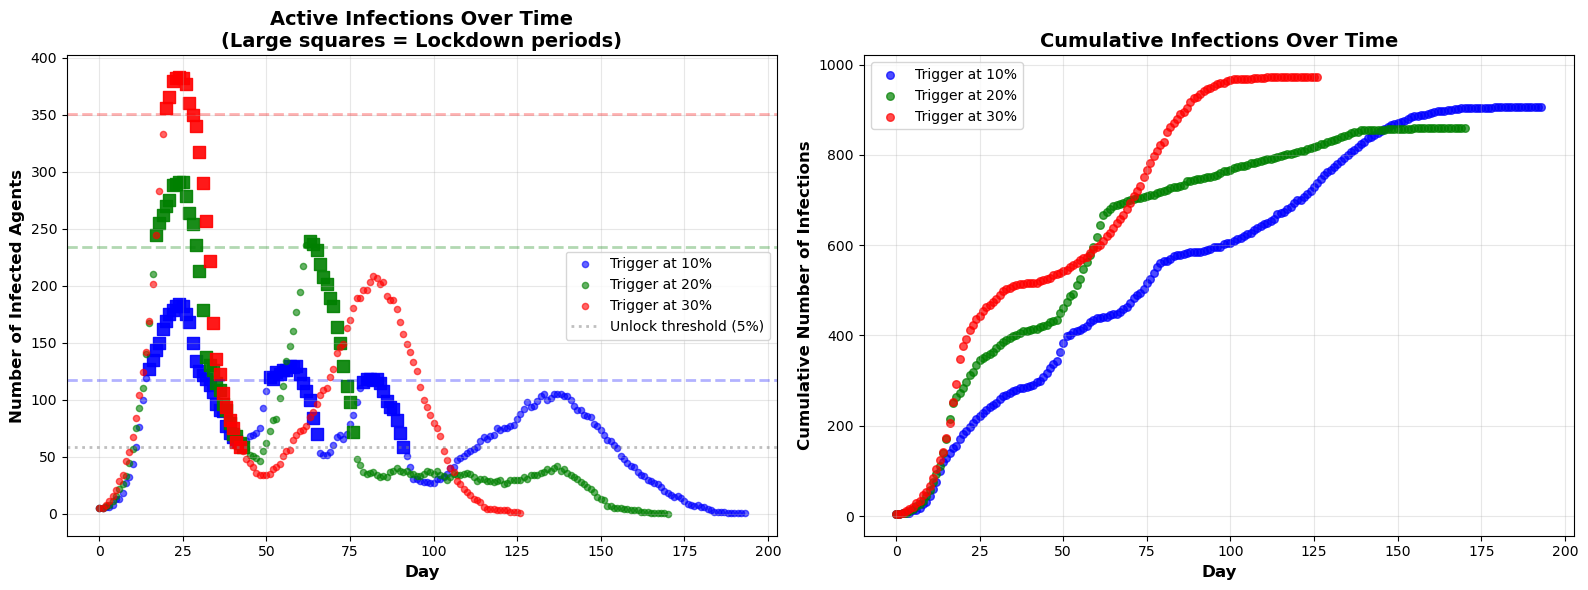


Visualization saved as 'circuit_breaker_comparison.png'

SUMMARY COMPARISON

Trigger threshold: 10%
  Total infected: 905 (77.4%)
  Peak infections: 184 (15.7%)
  Days in lockdown: 55 (28.4% of epidemic)
  Epidemic duration: 193 days

Trigger threshold: 20%
  Total infected: 859 (73.4%)
  Peak infections: 291 (24.9%)
  Days in lockdown: 41 (24.0% of epidemic)
  Epidemic duration: 170 days

Trigger threshold: 30%
  Total infected: 972 (83.1%)
  Peak infections: 383 (32.7%)
  Days in lockdown: 23 (18.1% of epidemic)
  Epidemic duration: 126 days


In [917]:
def simulate_epidemic_with_circuit_breaker(n_days=SIMULATION_DAYS, initial_infected=INITIAL_INFECTED, 
                                          lockdown_threshold=0.25, unlock_threshold=0.05,
                                          lockdown_movement_factor=0.2, lockdown_transmission_factor=0.5,
                                          verbose=True):
    """
    Epidemic simulation with circuit breaker lockdown
    Runs until no active infections remain
    
    Args:
        n_days: Maximum simulation days (acts as safety limit)
        initial_infected: Number of initial infected
        lockdown_threshold: Fraction of population infected to trigger lockdown
        unlock_threshold: Fraction of population infected to lift lockdown
        lockdown_movement_factor: Multiply movement by this during lockdown
        lockdown_transmission_factor: Multiply transmission probability by this during lockdown
        verbose: Print progress
    """
    agents = initialize_population(N_AGENTS, initial_infected, for_r0_calculation=False)
    
    # Track unique agents that have ever been infected
    ever_infected_ids = set()
    for agent in agents:
        if agent.status == 'infected':
            ever_infected_ids.add(id(agent))
    
    stats = {
        'day': [],
        'susceptible': [],
        'infected': [],
        'recovered': [],
        'cumulative_infections': [],
        'lockdown_active': []
    }
    
    n_steps = int(n_days / DT)
    lockdown_active = False
    
    # Store original D for restoration
    original_D = D
    current_D = D
    
    if verbose:
        print(f"Circuit breaker parameters:")
        print(f"  Lockdown triggers at: {lockdown_threshold*100:.0f}% infected")
        print(f"  Lockdown lifts at: {unlock_threshold*100:.0f}% infected")
        print(f"  Lockdown movement: {lockdown_movement_factor*100:.0f}% of normal")
        print(f"  Lockdown transmission: {lockdown_transmission_factor*100:.0f}% of normal")
        print()
    
    for step in range(n_steps + 1):
        # Check lockdown status based on current infections
        n_infected = sum(1 for a in agents if a.status == 'infected')
        infection_fraction = n_infected / N_AGENTS
        
        # Check if epidemic has ended
        if step > 0 and n_infected == 0:
            if verbose:
                print(f"\n✓ Epidemic ended at day {step * DT:.1f} (no active infections)")
            break
        
        # Circuit breaker logic
        if not lockdown_active and infection_fraction >= lockdown_threshold:
            lockdown_active = True
            current_D = original_D * (lockdown_movement_factor ** 2)
            if verbose:
                print(f"🔒 LOCKDOWN TRIGGERED at day {step * DT:.1f} ({infection_fraction*100:.1f}% infected)")
        
        elif lockdown_active and infection_fraction <= unlock_threshold:
            lockdown_active = False
            current_D = original_D
            if verbose:
                print(f"🔓 LOCKDOWN LIFTED at day {step * DT:.1f} ({infection_fraction*100:.1f}% infected)")
        
        # Move all agents (skip on step 0)
        if step > 0:
            for agent in agents:
                agent.move(current_D, DT)
            
            # Attempt transmissions with lockdown factor
            if lockdown_active:
                # Temporarily modify transmission function during lockdown
                original_transmission_func = transmission_probability_distance
                
                def lockdown_transmission(distance, minimum_proximity=0.0):
                    return original_transmission_func(distance, minimum_proximity) * lockdown_transmission_factor
                
                # Monkey patch the transmission function
                import sys
                current_module = sys.modules[__name__]
                setattr(current_module, 'transmission_probability_distance', lockdown_transmission)
                
                new_infections = transmission_step_optimized(agents, for_r0_calculation=False)
                
                # Restore original function
                setattr(current_module, 'transmission_probability_distance', original_transmission_func)
            else:
                new_infections = transmission_step_optimized(agents, for_r0_calculation=False)
            
            # Update set of ever-infected agents
            for agent in agents:
                if agent.status == 'infected':
                    ever_infected_ids.add(id(agent))
            
            # Update infection status
            for agent in agents:
                agent.update_infection_status(DT)
        
        # Record statistics every 4 steps (once per day)
        if step % 4 == 0:
            current_day = step * DT
            n_susceptible = sum(1 for a in agents if a.status == 'susceptible')
            n_infected = sum(1 for a in agents if a.status == 'infected')
            n_recovered = sum(1 for a in agents if a.status == 'recovered')
            cumulative = len(ever_infected_ids)
            
            stats['day'].append(current_day)
            stats['susceptible'].append(n_susceptible)
            stats['infected'].append(n_infected)
            stats['recovered'].append(n_recovered)
            stats['cumulative_infections'].append(cumulative)
            stats['lockdown_active'].append(lockdown_active)
            
            if verbose and int(current_day) % 10 == 0:
                lockdown_status = "🔒 LOCKDOWN" if lockdown_active else "🔓 Normal"
                print(f"Day {int(current_day)}: S={n_susceptible}, I={n_infected}, R={n_recovered}, "
                      f"Cumulative={cumulative} | {lockdown_status}")
    
    if verbose:
        final_cumulative = stats['cumulative_infections'][-1]
        print(f"\nFinal statistics:")
        print(f"Total infected: {final_cumulative} ({100*final_cumulative/N_AGENTS:.1f}%)")
        print(f"Final recovered: {stats['recovered'][-1]}")
        print(f"Remaining susceptible: {stats['susceptible'][-1]}")
        
        # Count lockdown periods
        lockdown_days = sum(stats['lockdown_active'])
        print(f"Total days in lockdown: {lockdown_days} ({100*lockdown_days/len(stats['day']):.1f}%)")
    
    return stats, agents

# Run multiple circuit breaker simulations with different trigger thresholds
print("="*80)
print("CIRCUIT BREAKER COMPARISON - VARYING TRIGGER THRESHOLDS")
print("="*80)

lockdown_thresholds = [0.10, 0.20, 0.30]  # 10%, 20%, 30%
colors = ['blue', 'green', 'red']  # Different color for each
all_results = []

for lockdown_thresh in lockdown_thresholds:
    print(f"\n{'='*80}")
    print(f"Running simulation with lockdown trigger = {lockdown_thresh*100:.0f}%")
    print(f"{'='*80}")
    
    start = time.time()
    cb_stats, cb_agents = simulate_epidemic_with_circuit_breaker(
        n_days=200,
        initial_infected=5,
        lockdown_threshold=lockdown_thresh,
        unlock_threshold=0.05,  # Fixed at 5%
        lockdown_movement_factor=0.1,
        lockdown_transmission_factor=0.25,
        verbose=True
    )
    end = time.time()
    
    all_results.append({
        'lockdown_threshold': lockdown_thresh,
        'stats': cb_stats,
        'computation_time': end - start
    })

print(f"\n{'='*80}")
print("ALL SIMULATIONS COMPLETE")
print(f"{'='*80}")

# Two-panel comparison plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Active infections
ax1 = axes[0]
for i, result in enumerate(all_results):
    stats = result['stats']
    lockdown_thresh = result['lockdown_threshold']
    color = colors[i]
    
    # Separate points into lockdown and normal periods
    days_normal = [stats['day'][j] for j in range(len(stats['day'])) if not stats['lockdown_active'][j]]
    infected_normal = [stats['infected'][j] for j in range(len(stats['infected'])) if not stats['lockdown_active'][j]]
    
    days_lockdown = [stats['day'][j] for j in range(len(stats['day'])) if stats['lockdown_active'][j]]
    infected_lockdown = [stats['infected'][j] for j in range(len(stats['infected'])) if stats['lockdown_active'][j]]
    
    # Plot normal periods (small dots)
    ax1.scatter(days_normal, infected_normal, c=color, s=20, alpha=0.6, 
                label=f'Trigger at {lockdown_thresh*100:.0f}%')
    
    # Plot lockdown periods (large squares)
    ax1.scatter(days_lockdown, infected_lockdown, c=color, s=80, alpha=0.9, marker='s')

# Add horizontal lines for each trigger threshold
for i, result in enumerate(all_results):
    lockdown_thresh = result['lockdown_threshold']
    color = colors[i]
    ax1.axhline(y=N_AGENTS*lockdown_thresh, color=color, linestyle='--', alpha=0.3, linewidth=2)

ax1.axhline(y=N_AGENTS*0.05, color='gray', linestyle=':', alpha=0.5, linewidth=2, 
            label='Unlock threshold (5%)')
ax1.set_xlabel('Day', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Infected Agents', fontsize=12, fontweight='bold')
ax1.set_title('Active Infections Over Time\n(Large squares = Lockdown periods)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)

# Plot 2: Cumulative infections
ax2 = axes[1]
for i, result in enumerate(all_results):
    stats = result['stats']
    lockdown_thresh = result['lockdown_threshold']
    color = colors[i]
    
    ax2.scatter(stats['day'], stats['cumulative_infections'], c=color, s=30, alpha=0.7,
                label=f'Trigger at {lockdown_thresh*100:.0f}%')

ax2.set_xlabel('Day', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cumulative Number of Infections', fontsize=12, fontweight='bold')
ax2.set_title('Cumulative Infections Over Time', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)

plt.tight_layout()
plt.savefig('circuit_breaker_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved as 'circuit_breaker_comparison.png'")

# Print summary comparison
print("\n" + "="*80)
print("SUMMARY COMPARISON")
print("="*80)
for result in all_results:
    stats = result['stats']
    lockdown_thresh = result['lockdown_threshold']
    lockdown_days = sum(stats['lockdown_active'])
    total_infected = stats['cumulative_infections'][-1]
    attack_rate = 100 * total_infected / N_AGENTS
    peak_infected = max(stats['infected'])
    
    print(f"\nTrigger threshold: {lockdown_thresh*100:.0f}%")
    print(f"  Total infected: {total_infected} ({attack_rate:.1f}%)")
    print(f"  Peak infections: {peak_infected} ({100*peak_infected/N_AGENTS:.1f}%)")
    print(f"  Days in lockdown: {lockdown_days} ({100*lockdown_days/len(stats['day']):.1f}% of epidemic)")
    print(f"  Epidemic duration: {stats['day'][-1]:.0f} days")

Cell 9

In [453]:

# Create summary statistics
summary = pd.DataFrame({
    'Parameter': [
        'Grid Size', 
        'Population', 
        'Population Density',
        'Diffusion Coefficient (D)',
        'Expected Daily Movement (RMS)',
        'Simulation Days',
        'Basic Reproduction Number (R0)',
        'Peak Infected',
        'Day of Peak',
        'Total Ever Infected',
        'Attack Rate (%)',
        'Final Susceptible'
    ],
    'Value': [
        f'{GRID_SIZE} km × {GRID_SIZE} km',
        N_AGENTS,
        f'{POPULATION_DENSITY} per km²',
        f'{D} km²/day',
        f'{np.sqrt(2*D*DT):.2f} km/day',
        SIMULATION_DAYS,
        f'{r0_value:.2f}',
        max(epidemic_stats['infected']),
        epidemic_stats['infected'].index(max(epidemic_stats['infected'])),
        epidemic_stats['cumulative_infections'][-1],
        f"{100 * epidemic_stats['cumulative_infections'][-1] / N_AGENTS:.1f}%",
        epidemic_stats['susceptible'][-1]
    ]
})

print("\n" + "="*60)
print("SIMULATION SUMMARY")
print("="*60)
print(summary.to_string(index=False))
print("="*60)

# Save to CSV
summary.to_csv('simulation_summary.csv', index=False)
print("\nSummary saved to 'simulation_summary.csv'")


SIMULATION SUMMARY
                     Parameter           Value
                     Grid Size 0.5 km × 0.5 km
                    Population            1170
            Population Density    4680 per km²
     Diffusion Coefficient (D)  0.2116 km²/day
 Expected Daily Movement (RMS)     0.33 km/day
               Simulation Days              50
Basic Reproduction Number (R0)            4.20
                 Peak Infected             718
                   Day of Peak              35
           Total Ever Infected            1064
               Attack Rate (%)           90.9%
             Final Susceptible             106

Summary saved to 'simulation_summary.csv'
